# Training and finding best model for the submission

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# loading data
df = pd.read_csv("../data2/train.csv", index_col='id')
test_df = pd.read_csv("../data2/test.csv", index_col='id')

In [3]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
len(df.engine.unique())

1117

In [5]:
# functions

# function to handle transmission 
def get_transmission_type(text):
    if 'M/T' in text or 'Manual' in text:
        return 'Manual'
    elif 'A/T' in text or 'Automatic' in text:
        return 'Automatic'
    elif 'CVT' in text:
        return 'CVT'
    else:
        return 'Other'

def get_num_speeds(text):
    match = re.search(r'(\d+)-Speed', text)
    if match:
        return int(match.group(1))
    else:
        return 0

def get_shift_mode(text):
    if 'Dual Shift' in text or 'Auto-Shift' in text:
        return 'Dual/Auto-Shift'
    elif 'Manual' in text:
        return 'Manual'
    else:
        return 'Standard'

def get_transmission_technology(text):
    if 'DCT' in text:
        return 'DCT'
    elif 'CVT' in text:
        return 'CVT'
    elif 'Auto-Shift' in text:
        return 'Auto-Shift'
    else:
        return 'unknown'

def get_production_status(text):
    if 'SCHEDULED' in text:
        return 1
    else:
        return 0


# extract horse power
def extract_hp(text):
    '''func to extract hp'''
    hp_match = re.search(r'(\d+\.?\d*)HP', text)
    return float(hp_match.group(1)) if hp_match else 0

# extract fuel capacity
def extract_fc(text):
    '''func to extract fuel capacity'''
    fc_match = re.search(r'(\d+\.?\d*)L', text)
    return float(fc_match.group(1)) if fc_match else 0




def feature_extractor(df):
    '''func to extract features from the dataframe'''
    df = df.copy()
    df['horse_power'] = df['engine'].apply(extract_hp)
    df['fuel_capacity'] = df['engine'].apply(extract_fc)
    df['trans_type'] = df.transmission.apply(get_transmission_type)
    df['num_speed'] = df.transmission.apply(get_num_speeds)
    df['shift_mode'] = df.transmission.apply(get_shift_mode)
    df['trans_tech'] = df.transmission.apply(get_transmission_technology)
    df['prod_status'] = df.transmission.apply(get_production_status)
    df['age'] = 2025 - df.model_year
    df['milage_per_year'] = (df['milage'] / df['age'])
    df['score'] = df['horse_power'] + df['fuel_capacity'] + df['num_speed'] + df['milage_per_year']
    df['brand_model'] = df['brand'].str.cat(df['model'], sep=' ')
    df['per_score'] = df['horse_power'] + df['num_speed']

    return df


def handle_nan(df):
    '''func to handle missing values'''
    df = df.copy()
    df['fuel_type'] = df['fuel_type'].replace([np.nan, '–'], 'missing')
    df['accident'] = df['accident'].replace([np.nan], 'None reported')
    df['clean_title'] = df['clean_title'].replace(np.nan, 'no')
    
    return df

In [6]:
# cetegorize features

def ordinal_feature_labeler(df ,features_list, target):
    ''' 
    This function will label categorical features list features to ordinal label.
    '''
    transformed_df = pd.DataFrame({"temp":np.arange(df.shape[0])}, index=df.index)

    transformed_label_data = {}

    for feature in features_list:
        ordered_values = df.groupby([feature])[target].median().sort_values().index.to_list()
        n = len(ordered_values)

        value_dict = {i:j for i, j in zip(ordered_values, list(range(n)))}

        # copy the categories values data
        transformed_label_data[feature] = value_dict.copy()

        transformed_df[feature] = df[feature].apply(lambda x: value_dict[x])
    
    transformed_df.drop(['temp'], axis=1, inplace=True)

    return transformed_df, transformed_label_data


def label_from_dict(df, label_dict):
    """
    Transforms the given df categorical labels according to given dict labels.
    """
    temp_df = df.copy()

    for feature in label_dict.keys():
        labels = label_dict[feature]
        temp_df[feature] = temp_df[feature].apply(lambda x: labels[x] if x in labels.keys() else len(label_dict) / 2)

    return temp_df




In [7]:
# applying transformation
df = feature_extractor(df)
df = handle_nan(df)



# doing same for test_df
test_df = feature_extractor(test_df)
test_df = handle_nan(test_df)

In [8]:
# bining 
ord_col = ['brand', 'model', 'ext_col', 'int_col', 'fuel_type', 'brand_model']
cat_col = ['accident', 'clean_title', 'trans_type', 'shift_mode', 'trans_tech', 'prod_status']
num_col = [ 'horse_power', 'fuel_capacity', 'num_speed', 'age', 'milage_per_year', 'score', 'ord_score', 'milage', 'per_score']
drop_col = ['model_year', 'price', 'engine', 'transmission']

In [9]:
temp_df, labels = ordinal_feature_labeler(df, ord_col, 'price')


df = label_from_dict(df, labels)
test_df = label_from_dict(test_df, labels)

df['ord_score'] = df[ord_col].sum(axis=1)
test_df['ord_score'] = df[ord_col].sum(axis=1)


df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,num_speed,shift_mode,trans_tech,prod_status,age,milage_per_year,score,brand_model,per_score,ord_score
id,,,,,,,,,,,,,,,,,,,,,
0,6,158,2007,213000,2,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,14,0,None reported,...,0,Standard,unknown,0,18,11833.333333,12006.933333,431,172.0,611
1,23,141,2002,143250,2,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,3,2,At least 1 accident or damage reported,...,0,Standard,unknown,0,23,6228.260870,6484.160870,323,252.0,494
2,35,688,2002,136731,1,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,31,0,None reported,...,0,Standard,unknown,0,23,5944.826087,6270.126087,1335,320.0,2090
3,42,1384,2017,19500,2,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,27,25,None reported,...,0,Dual/Auto-Shift,unknown,0,8,2437.500000,2862.500000,2464,420.0,3944
4,38,1461,2021,7388,2,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,27,2,None reported,...,7,Standard,unknown,0,4,1847.000000,2064.000000,2600,215.0,4130


In [10]:
# applying transformation 
target = df['price']
df = df.drop(drop_col, axis=1)


# removing price as price is not in drop col
drop_col.remove('price')

# droping form test_df
test_df = test_df.drop(drop_col, axis=1)


col_names = df.columns.tolist()

In [11]:

# transformation pipeline
trans_pipe = ColumnTransformer([
    ('num', StandardScaler(), num_col),
    ('cat', OneHotEncoder(drop='if_binary'), cat_col),
    # ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=2000), ord_col)
], remainder='passthrough')

# scaler = StandardScaler()

# preprocessing
trans_df = trans_pipe.fit_transform(df)
trans_test_df = trans_pipe.transform(test_df)

# trans_df = scaler.fit_transform(trans_df)
# trans_test_df = scaler.transform(trans_test_df)

In [12]:
temp_test_trans_df = pd.DataFrame(data=trans_test_df, index=test_df.index)
temp_test_trans_df.to_csv('../data2/test_data_for_colab.csv')

In [29]:
temp_test_trans_df.isna().sum()

0          0
1          0
2          0
3          0
4          0
5          0
6     125690
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
dtype: int64

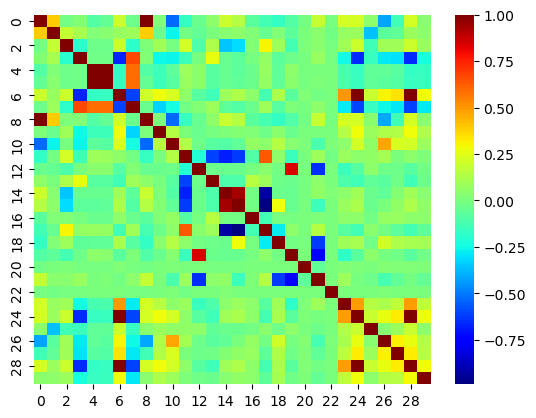

In [14]:
# find out correlation with price
temp_df = pd.DataFrame(data=trans_df)
temp_df['price'] = target

temp_df.to_csv('../data2/dataforcolab.csv')

sns.heatmap(temp_df.corr(), cmap='jet')
plt.show()

In [15]:
# model training
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

X_train, X_test, y_train, y_test = train_test_split(trans_df, target, test_size=0.2, random_state=42)

# model training
model = LinearRegression()

model.fit(X_train, y_train)

# metrics printing
print("Linear model rmse:", mean_squared_error(y_test, model.predict(X_test), squared=False))
print("Linear model R2 Score:", r2_score(y_test, model.predict(X_test)))


Linear model rmse: 69490.70656420618
Linear model R2 Score: 0.13165971243806762


In [16]:
# lasso
lasso = Lasso(100)
lasso.fit(X_train, y_train)
print("Lasso model rmse:", mean_squared_error(y_test, lasso.predict(X_test), squared=False))
print("Lasso model R2 Score:", r2_score(y_test, lasso.predict(X_test)))


Lasso model rmse: 69560.52960080325
Lasso model R2 Score: 0.1299138497542064


In [17]:
from sklearn.linear_model import LassoCV

# lassoCV
lassocv = LassoCV(n_alphas=1000)
lassocv.fit(X_train, y_train)
print("LassoCV model rmse:", mean_squared_error(y_test, lassocv.predict(X_test), squared=False))
print("LassoCV model R2 Score:", r2_score(y_test, lassocv.predict(X_test)))


LassoCV model rmse: 70539.73618062663
LassoCV model R2 Score: 0.10524495010625867


In [18]:
# ridge
ridge = Ridge(200)
ridge.fit(X_train, y_train)
print("Ridge model rmse:", mean_squared_error(y_test, ridge.predict(X_test), squared=False))
print("Ridge model R2 Score:", r2_score(y_test, ridge.predict(X_test)))


Ridge model rmse: 69502.39880790617
Ridge model R2 Score: 0.13136748054409264


In [19]:
# using ensemble techniques

import xgboost as xgb


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
d_test = xgb.DMatrix(trans_test_df)

param = {
    'objective' : "reg:squarederror",
    'max_depth' : 5,
    'eta' : 0.07,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8
}

num_rounds = 100

bst = xgb.train(param, dtrain, num_rounds)

print("xgboost model rmse:", mean_squared_error(y_test, bst.predict(dtest), squared=False))
print("XGBoost model R2 Score:", r2_score(y_test, bst.predict(dtest)))



xgboost model rmse: 67790.76729241121
XGBoost model R2 Score: 0.1736241579055786


In [20]:
# decision tree regressor
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)
print("dt model rmse:", mean_squared_error(y_test, dt_reg.predict(X_test), squared=False))
print("dt model R2 Score:", r2_score(y_test, dt_reg.predict(X_test)))

dt model rmse: 104761.19018412186
dt model R2 Score: -0.9735009672025148


In [21]:
xgboost_prediction = bst.predict(d_test)

def submission_file_maker(predicted_price, model_name):
    sub = pd.DataFrame({
        'id': test_df.index,
        'price': predicted_price
    })

    sub.to_csv(f"../data2/submission_{model_name}.csv", index=False)

submission_file_maker(xgboost_prediction, 'xgb_300924')

In [22]:
# CatBoost & LGBM models

In [23]:
import lightgbm as lgb

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Set parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1
}

# Train the model
bst = lgb.train(params, train_data, num_boost_round=100)

# Predict on test set
y_pred = bst.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')
print("XGBoost model R2 Score:", r2_score(y_test, y_pred))

RMSE: 67524.18123069714
XGBoost model R2 Score: 0.18011083023628915


In [24]:
# import shap

# # Create SHAP explainer
# explainer = shap.TreeExplainer(bst)

# # Calculate SHAP values
# shap_values = explainer.shap_values(X_train)

# # Visualize feature importance using SHAP summary plot
# shap.summary_plot(shap_values, X_train)


In [25]:
# from sklearn.feature_selection import RFE
# from lightgbm import LGBMRegressor  # or LGBMClassifier for classification

# # LightGBM model
# model = LGBMRegressor()

# # Recursive Feature Elimination (RFE)
# rfe = RFE(model, n_features_to_select=15)  # Select top 10 features
# rfe = rfe.fit(X_train, y_train)

# # Get the selected features
# selected_features = x_train[:, rfe.support_]

# print("Selected features:", selected_features)


In [26]:
# X_train[:, rfe.support_]

In [27]:
# import lightgbm as lgb
# import warnings

# warnings.filterwarnings('ignore')

# best_score = float('inf')
# bf = 100
# bm = bst

# for i in range(1, len(X_train[0])):
#     model = LGBMRegressor(verbose= -1)

#     # Recursive Feature Elimination (RFE)
#     rfe = RFE(model, n_features_to_select=i)  # Select top 10 features
#     rfe = rfe.fit(X_train, y_train)

#     # Create LightGBM dataset
#     train_data = lgb.Dataset(X_train[:, rfe.support_], label=y_train)
    
#     # Set parameters
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'learning_rate': 0.05,
#         'num_leaves': 31,
#         'boosting_type': 'gbdt',
#         'verbose': -1
#     }
    
#     # Train the model
#     bst = lgb.train(params, train_data, num_boost_round=100)
    
#     # Predict on test set
#     y_pred = bst.predict(X_test[:, rfe.support_])
    
#     # Evaluate the model
#     rmse = mean_squared_error(y_test, y_pred, squared=False)

#     print("#" * 20, f'\n iteration: {i}\n')
    
#     print(f'RMSE: {rmse}')
#     print("lgbm model R2 Score:", r2_score(y_test, y_pred))

#     if rmse < best_score:
#         bf = i
#         best_score = rmse
#         bm = bst


In [28]:
print('best num features:', bf)
print('best score:', best_score)

NameError: name 'bf' is not defined

In [ ]:
# i = 24

# model = LGBMRegressor(verbose= -1)

# # Recursive Feature Elimination (RFE)
# rfe = RFE(model, n_features_to_select=i)  # Select top 10 features
# rfe = rfe.fit(X_train, y_train)

# # Create LightGBM dataset
# train_data = lgb.Dataset(X_train[:, rfe.support_], label=y_train)

# # Set parameters
# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'learning_rate': 0.05,
#     'num_leaves': 31,
#     'boosting_type': 'gbdt',
#     'verbose': -1
# }

# # Train the model
# bst = lgb.train(params, train_data, num_boost_round=100)

# # Predict on test set
# y_pred = bst.predict(X_test[:, rfe.support_])

# # Evaluate the model
# rmse = mean_squared_error(y_test, y_pred, squared=False)

# print("#" * 20, f'\n iteration: {i}\n')

# print(f'RMSE: {rmse}')
# print("lgbm model R2 Score:", r2_score(y_test, y_pred))

In [ ]:
lgb_pred = bm.predict(trans_test_df[:, rfe.support_])
submission_file_maker(lgb_pred, 'lgb_300924-0001')

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# model = LGBMRegressor(verbose= -1)

# # Define parameter distribution
# param_dist = {
#     'num_leaves': list(range(20, 51)),  # Random values between 20 and 150
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'n_estimators': [50, 100, 200, 300]
# }

# # Perform random search
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
#                                    n_iter=50, scoring='neg_root_mean_squared_error', 
#                                    cv=5, verbose=1, n_jobs=-1, random_state=42)

# random_search.fit(X_train, y_train)

# # Best parameters and best score
# print("Best Parameters:", random_search.best_params_)
# print("Best RMSE:", -random_search.best_score_)
